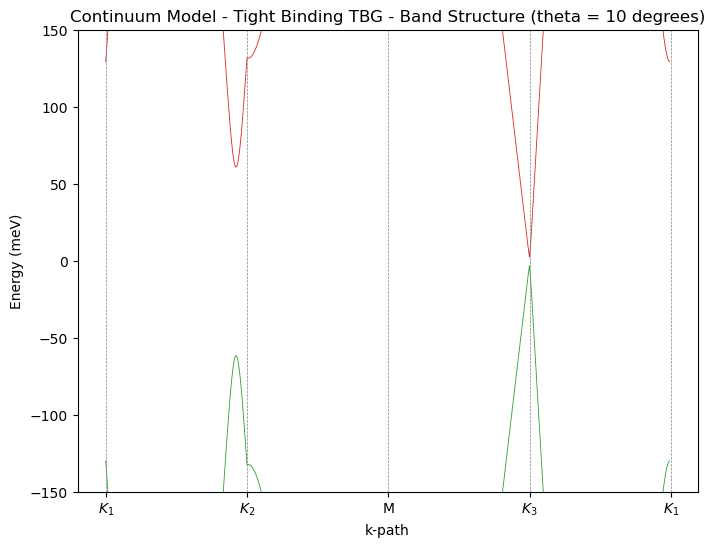

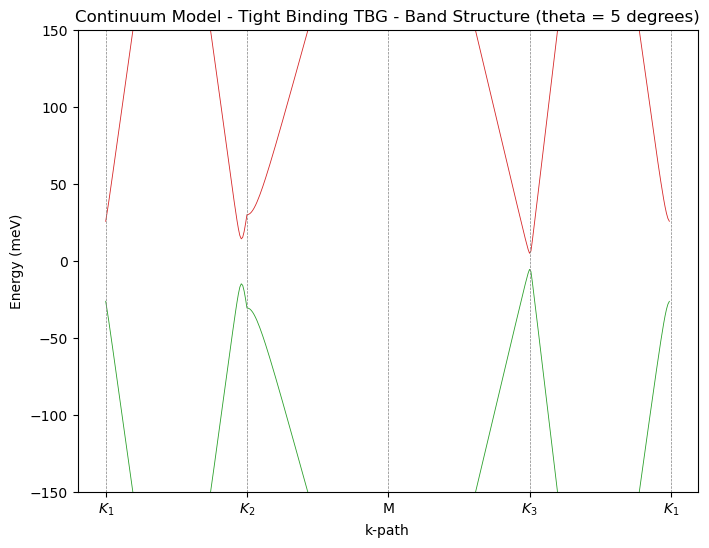

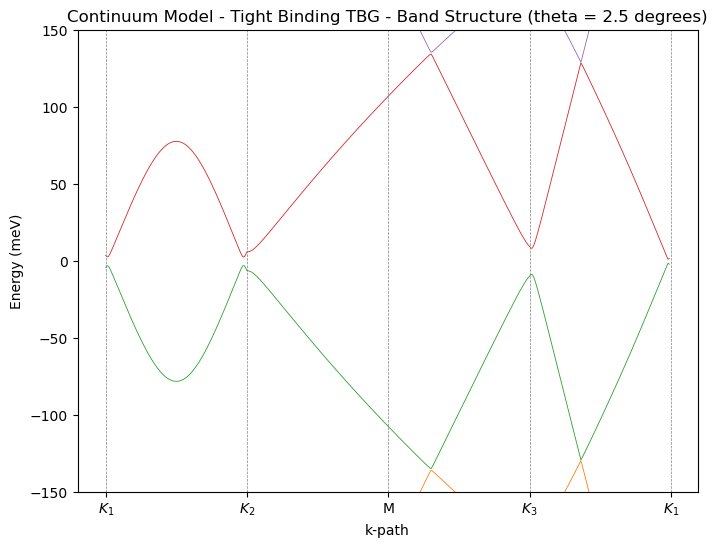

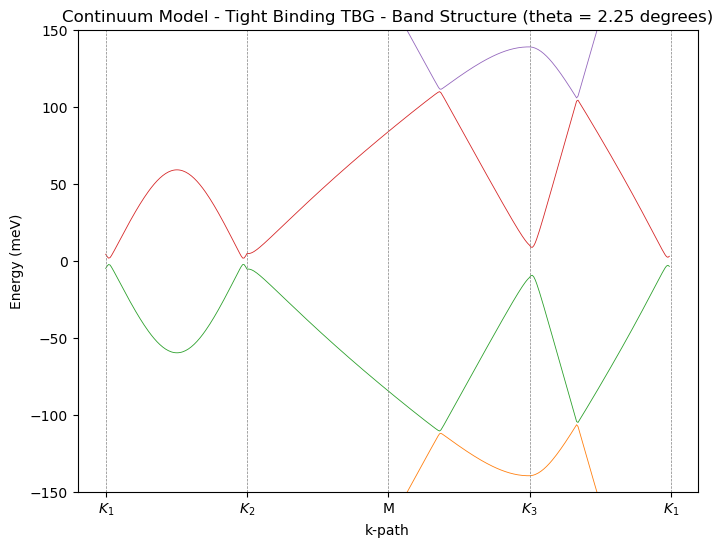

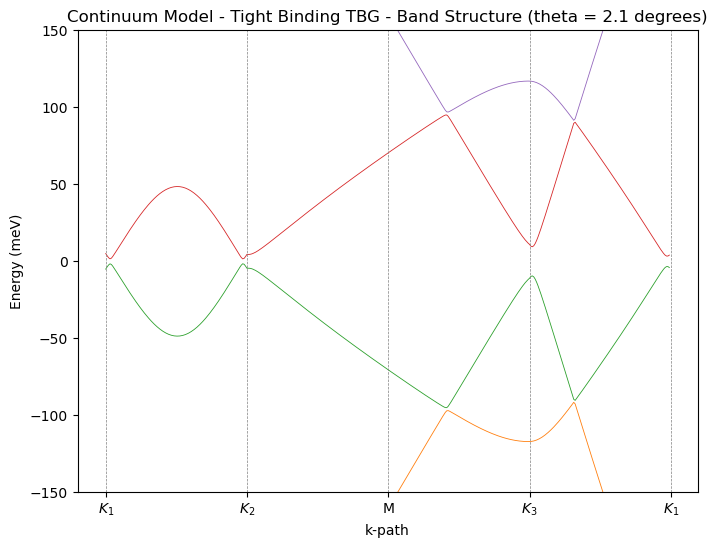

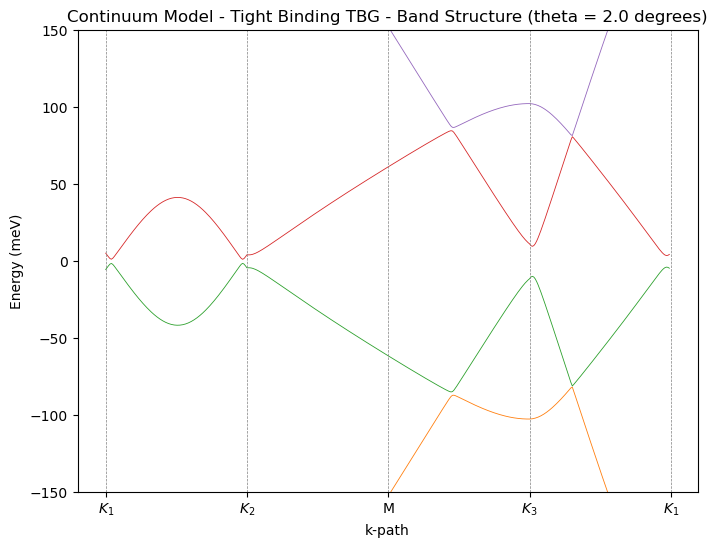

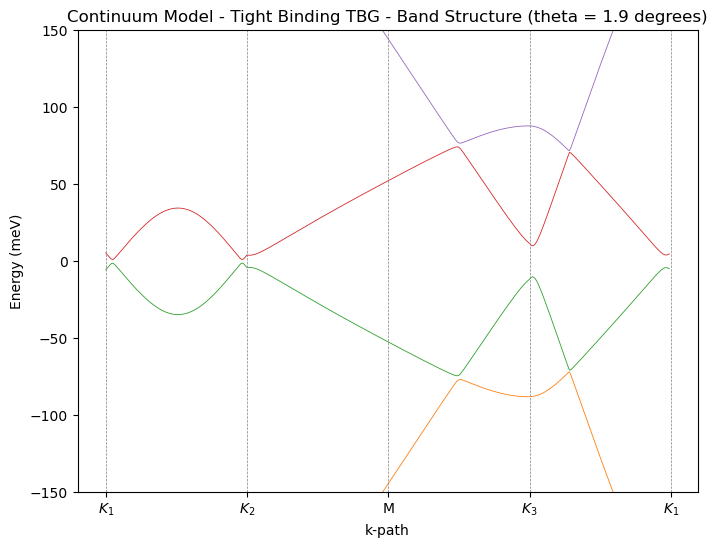

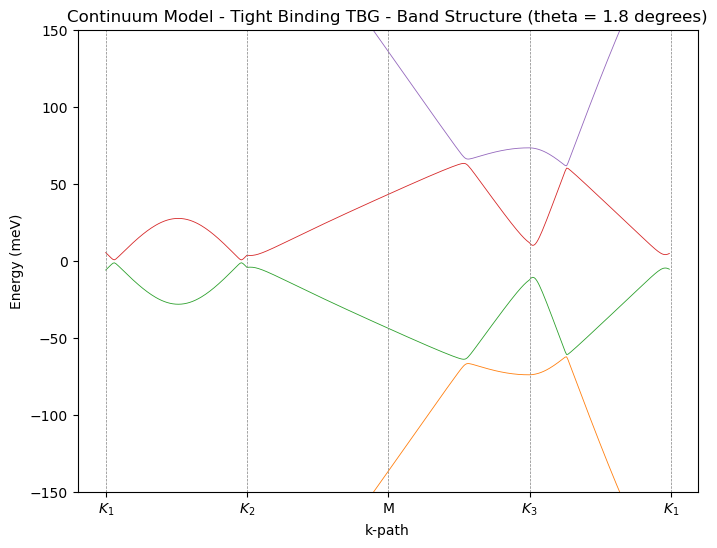

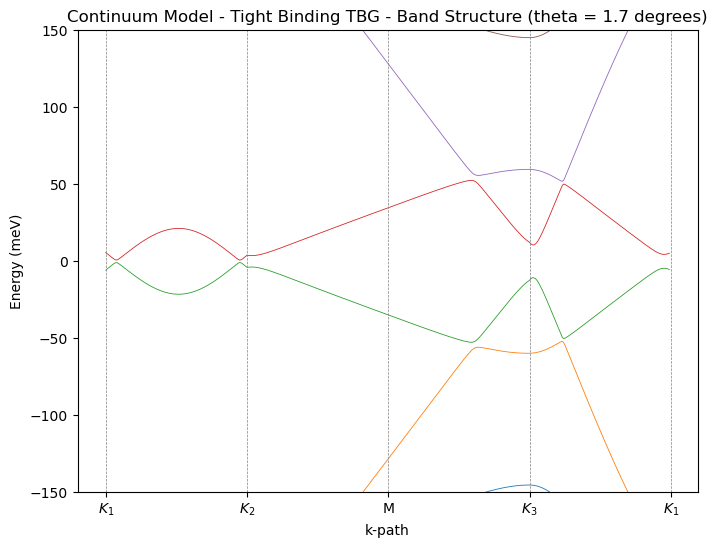

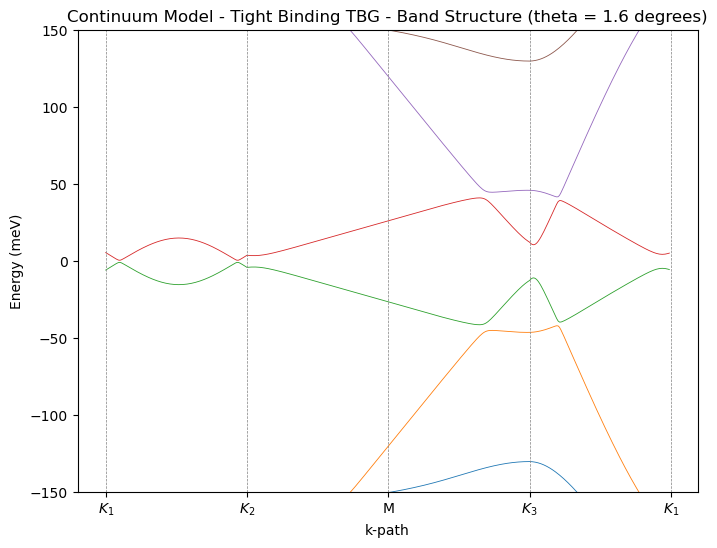

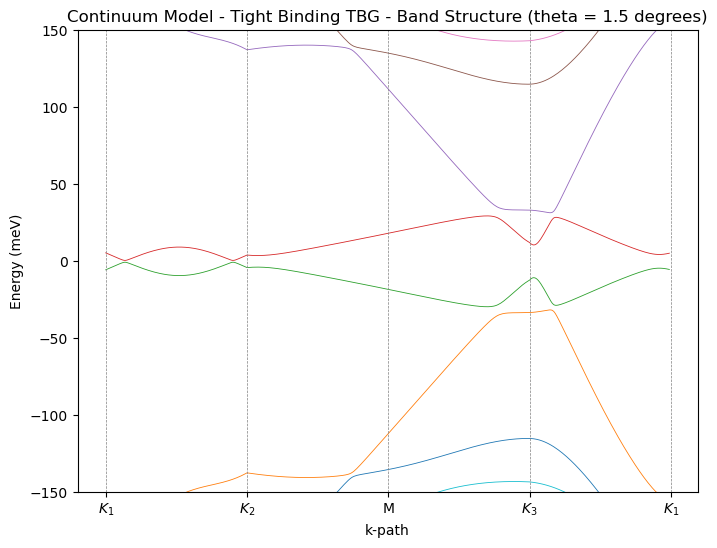

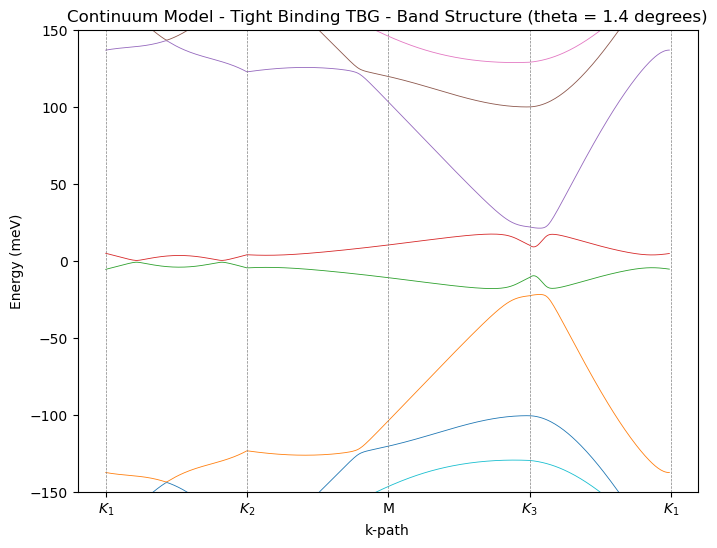

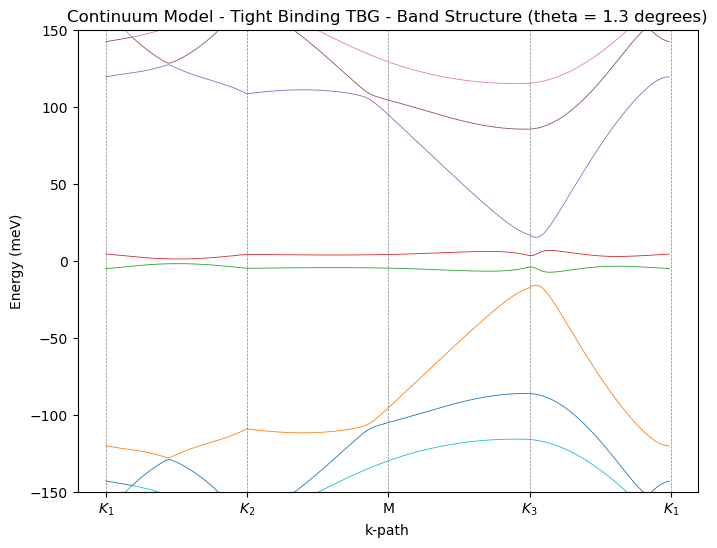

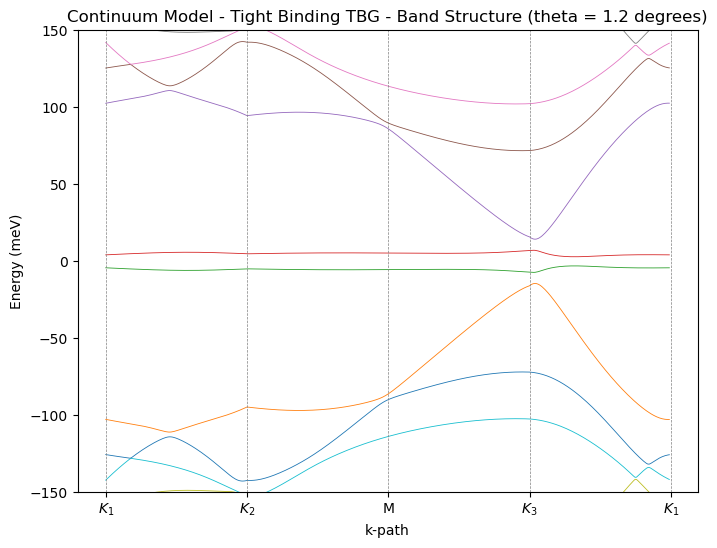

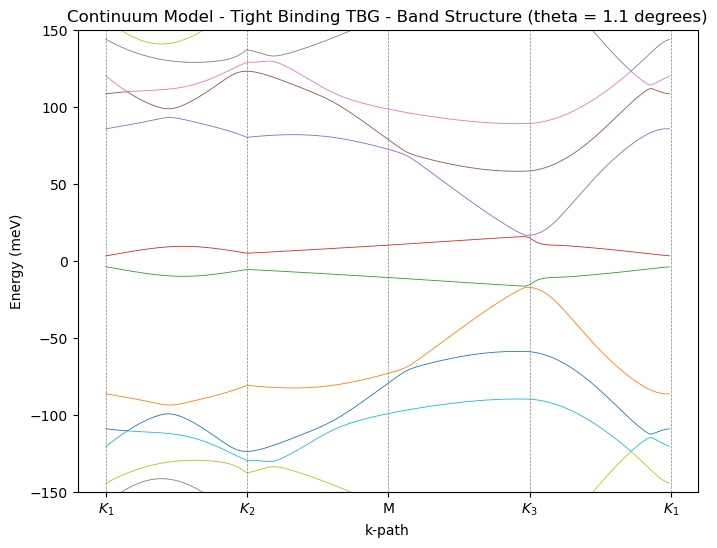

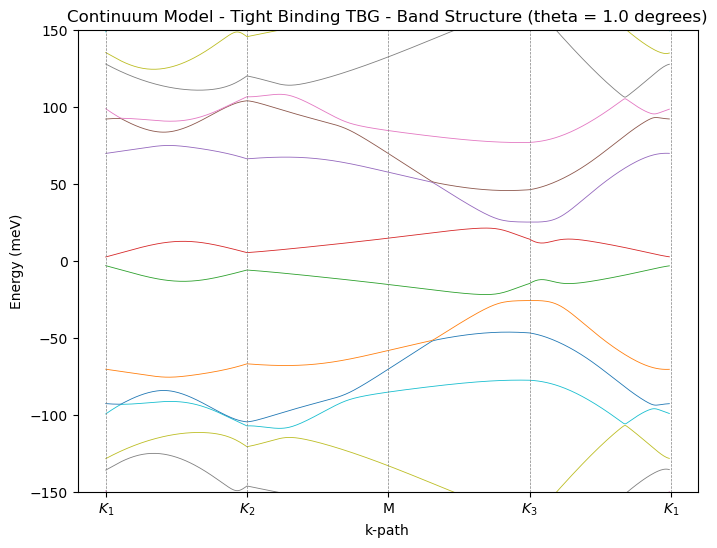

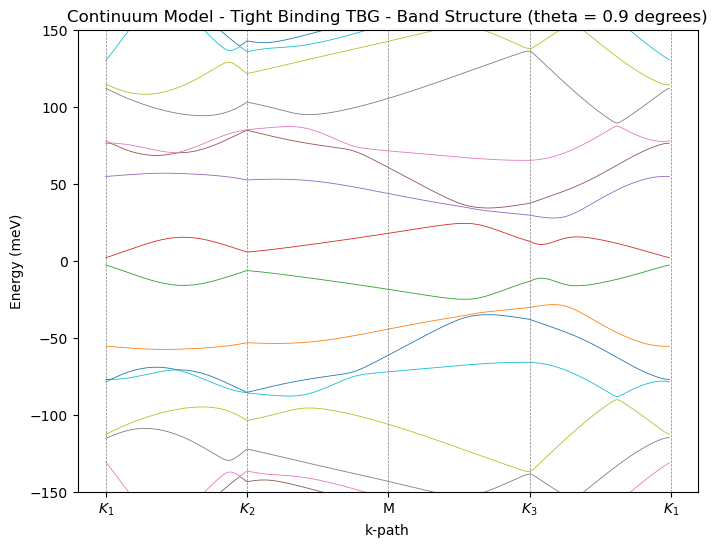

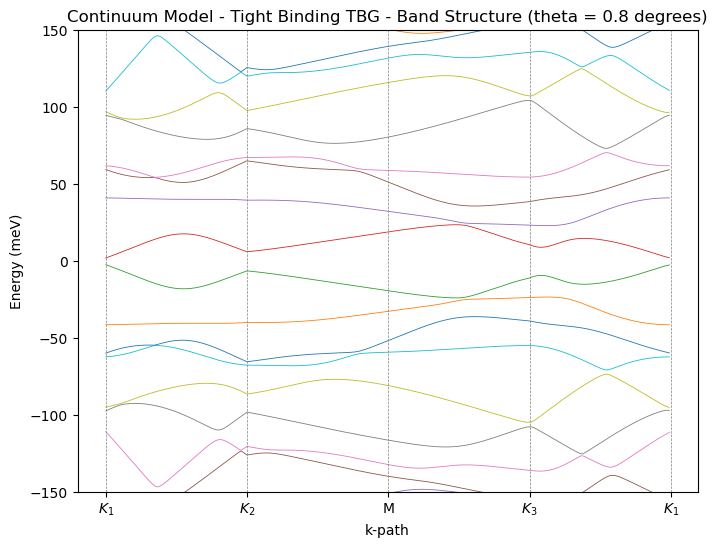

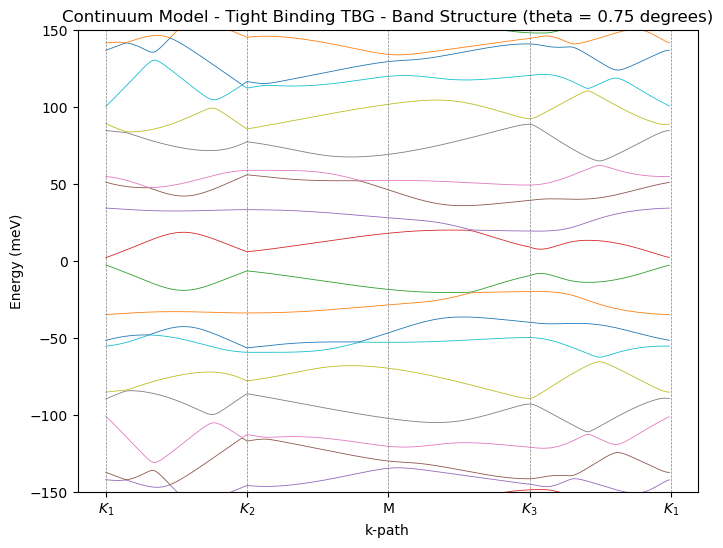

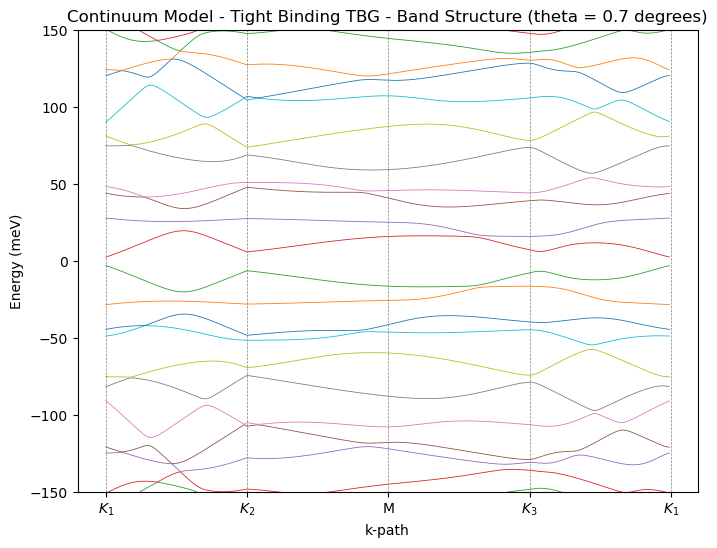

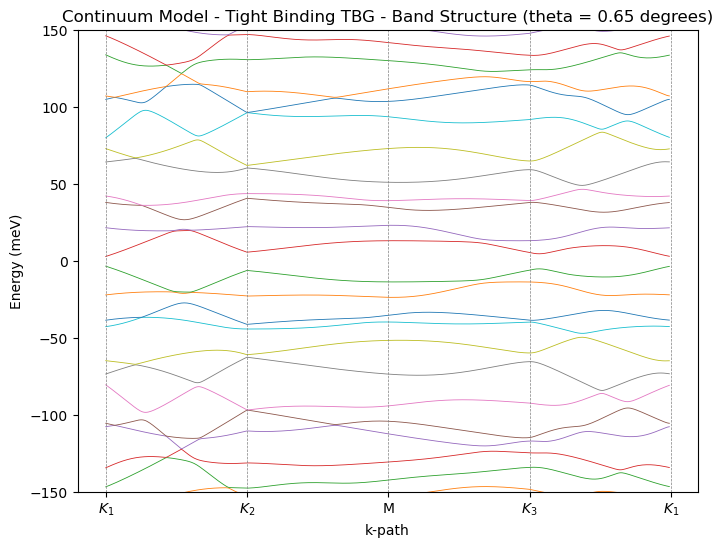

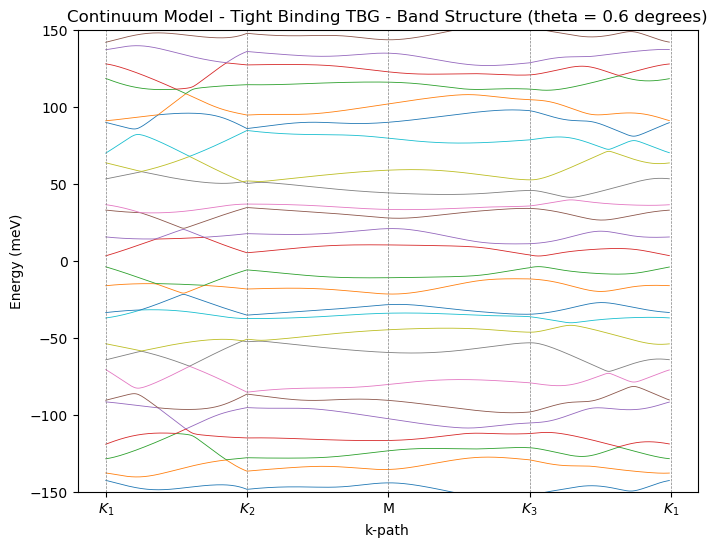

In [3]:
import numpy as np
import matplotlib.pyplot as plt

""" PARAMETERS """
# Parameters
n_layers = 3
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 2135.4 * a  # Fermi Velocity + Plank's Constant meV*angstrom

valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

w_ab = 110  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex) # Identity
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex) # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex) # Pauli Y

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def kronecker_delta_momentum(q_diff, q_target):
    return np.all(np.abs(q_diff - q_target) < tolerance)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Calculate reciprocal lattice vectors between layers 1 and 2
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors    

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle):
    return w_aa * sigma_0 + w_ab * (np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y)

# Construction of the relevant Tunneling matrices # phi = lattice relaxation const to control/modulate the stacking configuration
T1_12 = tunneling_matrix(w_aa, w_ab, 0)
T2_12 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3)
T3_12 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3)


T1_23 = tunneling_matrix(w_aa, w_ab, 0)
T2_23 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3)
T3_23 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3)

# Generate moiré lattice vectors
siteN = (2 * N + 1) ** 2
L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    K1 = delk * np.array([np.sqrt(3)/2, 1/2])
    K2 = delk * np.array([np.sqrt(3)/2, -1/2])
    M = delk  * np.array([np.sqrt(3)/4, -1/4])
    K3 = delk * np.array([0, 0])
    End_K1 = delk * np.array([np.sqrt(3)/2, 1/2])

    
    # Generate the k-path segments
    kline1 = klines(K1, K2, npts)
    kline2 = klines(K2, M , npts)
    kline3 = klines(M , K3, npts)
    kline4 = klines(K3, End_K1, npts)
    
    
    # Labels for each segment
    klabels = [r'$K_1$',r'$K_2$',r'M',r'$K_3$',r'$K_1$']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1),4 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :],kline4[:-1, :])), kcoord, klabels

def Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m):
    # Initialize Hamiltonian
    H = np.zeros((6 * siteN, 6 * siteN), dtype=complex)

    # Loop through each lattice position to calculate q1, q2 and assign to Hamiltonian
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        # Compute q1 and q2 as arrays with x and y components
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m
        q3 = np.array([kx, ky]) - K3m + n1 * G1m + n2 * G2m

        # Assign intralayer terms for each layer
        H[2*i:2*i+2, 2*i:2*i+2] = -hv * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -hv * (valley * q2[0] * sigma_x + q2[1] * sigma_y)
        H[2*i+4*siteN:2*i+4*siteN+2, 2*i+4*siteN:2*i+4*siteN+2] = -hv * (valley * q3[0] * sigma_x + q3[1] * sigma_y)
        # Loop over other sites for interlayer coupling
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]

            # Set Kronecker delta values based on index shifts
            kd_0 = int((m1 == n1) and (m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((m1 == n1 - valley) and (m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((m1 == n1 - valley) and (m2 == n2 - valley))  # Checks if delta_q = q3

            # Combine tunneling matrices based on Kronecker delta values
            T_12 = kd_0 * T1_12 + kd_G1 * T2_12 + kd_G1G2 * T3_12
            T_23 = kd_0 * T1_23 + kd_G1 * T2_23 + kd_G1G2 * T3_23

            # Block assign the tunneling matrix T to the Hamiltonian
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T_12.conjugate()
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T_12
            
            H[2*i+2*siteN:2*i+2*siteN+2, 2*j+4*siteN:2*j+4*siteN+2] = T_23.conjugate().T
            H[2*j+4*siteN:2*j+4*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = T_23
            
    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)


def calc_bands_HTTG(theta_deg):
    # Convert theta to radians and recalculate delk for the new theta
    theta_rad = np.radians(theta_deg)
    theta_values = [theta_rad, 0.0, -theta_rad]
    delk = 8 * np.pi * np.sin(theta_rad / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
    
    # Recalculate rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Recalculate mBZ vectors G1m and G2m for the given theta
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # Recalculate K-point values and q vectors for the given theta
    K1m = (1/3) * G1m + (2/3) * G2m
    K2m = -(1/3) * G1m - (2/3) * G2m
    K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m)
    q1_12 = K2m - K1m
    q2_12 = np.dot(rotation_matrix(2 * np.pi / 3), q1_12)
    q3_12 = np.dot(rotation_matrix(4 * np.pi / 3), q1_12)
    K3m = K1m - q1_12


    # Call the function to plot the band structure for the current theta
    plot_band_structure(Hamiltonian, npts, delk, theta_deg, K1m, K2m, K3m, G1m, G2m)


        

def plot_band_structure(Hamiltonian, npts, delk, theta_deg,K1m, K2m, K3m, G1m, G2m):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = 6 * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg} degrees)")
    plt.ylim(-150, 150)
    plt.show()

def plot_geometry():
    # Calculate reciprocal lattice vectors between layers 1 and 2
    reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
    b1, b2 = reciprocal_vectors

    # Apply rotation to calculate the rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Calculate mBZ vectors G1m and G2m for layers 1 and 2
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # mBZ K-point values
    K1m = (1/3) * G1m + (2/3) * G2m
    K2m = -(1/3) * G1m - (2/3) * G2m
    K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m)
    q1_12 = K2m - K1m
    K3m = K1m - q1_12 

    print(K1m)
    print(K2m)
    print(K3m)
    print(q1_12)

    # Plot vectors
    plt.figure(figsize=(10, 10))
    origin = np.array([0, 0])

    # Plot G1m and G2m
    plt.quiver(*origin, *G1m, color='r', scale=1, scale_units='xy', angles='xy', label='G1m')
    plt.quiver(*origin, *G2m, color='b', scale=1, scale_units='xy', angles='xy', label='G2m')

    # Plot K-points
    plt.scatter(*K1m, color='g', label='K1m')
    plt.scatter(*K2m, color='purple', label='K2m')
    plt.scatter(*K3m, color='orange', label='K3m')

    # Plot q1_12
    plt.quiver(*K1m, *q1_12, color='black', scale=1, scale_units='xy', angles='xy', label='q1_12')

    # Customize plot to center at (0, 0) and set expanded limits
    plt.xlim(-2 * max(abs(G1m[0]), abs(G2m[0])), 2 * max(abs(G1m[0]), abs(G2m[0])))
    plt.ylim(-2 * max(abs(G1m[1]), abs(G2m[1])), 2 * max(abs(G1m[1]), abs(G2m[1])))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.title('Plot of K-points, G vectors, and q vectors')
    plt.legend()
    plt.grid(True)
    plt.show()
    

#plot_geometry()

theta_array = [10, 5, 2.5, 2.25, 2.1, 2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6]

for theta in theta_array:
    calc_bands_HTTG(theta)




[ 0.0113444  -0.99993565]


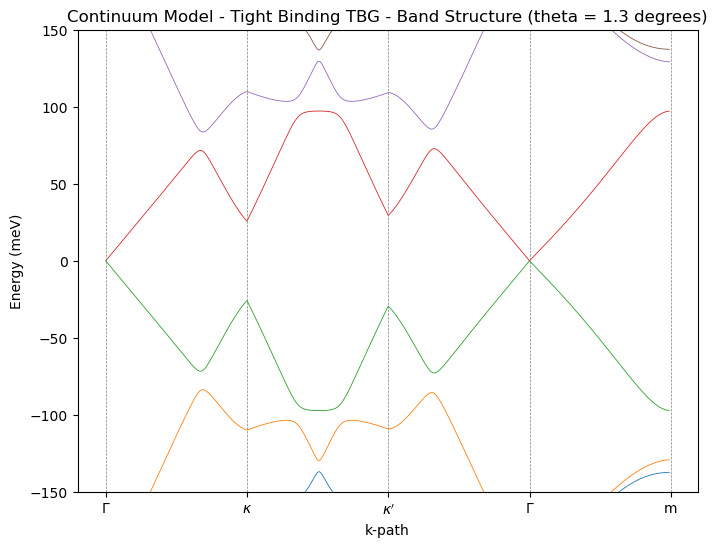

In [3]:
import numpy as np
import matplotlib.pyplot as plt

""" PARAMETERS """
# Parameters
n_layers = 3
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 6582.12  # Fermi Velocity + Plank's Constant meV*angstrom

valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

w_ab = 105  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex) # Identity
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex) # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex) # Pauli Y

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def kronecker_delta_momentum(q_diff, q_target):
    return np.all(np.abs(q_diff - q_target) < tolerance)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Calculate reciprocal lattice vectors between layers 1 and 2
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors    

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle,phi):
    return (w_aa * sigma_0 + w_ab * (np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y) ) * np.exp(1j * phi)

# Construction of the relevant Tunneling matrices # phi = lattice relaxation const to control/modulate the stacking configuration
# check placement of exp factor inside or outside?
# Check angles phi_AAA, -phiAAA or reverse?
T1_12 = tunneling_matrix(w_aa, w_ab, 0,-phi_ABA[0])
T2_12 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,-phi_ABA[1])
T3_12 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,-phi_ABA[2])


T1_23 = tunneling_matrix(w_aa, w_ab, 0,phi_ABA[0])
T2_23 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,phi_ABA[1])
T3_23 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,phi_ABA[2])

# Generate moiré lattice vectors
siteN = (2 * N + 1) ** 2
L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    K2 = delk * np.array([0, 0])
    kappa = delk * np.array([np.sqrt(3)/2, -1/2])
    kappa_prime = delk  * np.array([np.sqrt(3)/2, 1/2])
    K2 = delk * np.array([0, 0])
    m = delk * np.array([np.sqrt(3)/2, 0])

    
    # Generate the k-path segments
    kline1 = klines(K2, kappa, npts)
    kline2 = klines(kappa, kappa_prime , npts)
    kline3 = klines(kappa_prime , K2, npts)
    kline4 = klines(K2, m , npts)
    
    
    # Labels for each segment
    klabels = [r'$\Gamma$', r'$\kappa$', r'$\kappa^{\prime}$', r'$\Gamma$', r'm']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1),4 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :],kline4[:-1, :])), kcoord, klabels

def Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m):
    # Initialize Hamiltonian
    H = np.zeros((6 * siteN, 6 * siteN), dtype=complex)

    # Loop through each lattice position to calculate q1, q2 and assign to Hamiltonian
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        # Compute q1 and q2 as arrays with x and y components
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m
        q3 = np.array([kx, ky]) - K3m + n1 * G1m + n2 * G2m

        # Assign intralayer terms for each layer
        H[2*i:2*i+2, 2*i:2*i+2] = -hv * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -hv * (valley * q2[0] * sigma_x + q2[1] * sigma_y)
        H[2*i+4*siteN:2*i+4*siteN+2, 2*i+4*siteN:2*i+4*siteN+2] = -hv * (valley * q3[0] * sigma_x + q3[1] * sigma_y)
        # Loop over other sites for interlayer coupling
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]

            # Set Kronecker delta values based on index shifts
            kd_0 = int((m1 == n1) and (m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((m1 == n1 - valley) and (m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((m1 == n1 - valley) and (m2 == n2 - valley))  # Checks if delta_q = q3

            # Combine tunneling matrices based on Kronecker delta values
            T_12 = kd_0 * T1_12 + kd_G1 * T2_12 + kd_G1G2 * T3_12
            T_23 = kd_0 * T1_23 + kd_G1 * T2_23 + kd_G1G2 * T3_23

            # Block assign the tunneling matrix T to the Hamiltonian
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T_12.conjugate().T
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T_12
            
            H[2*i+2*siteN:2*i+2*siteN+2, 2*j+4*siteN:2*j+4*siteN+2] = T_23.conjugate().T
            H[2*j+4*siteN:2*j+4*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = T_23
            
    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)


def calc_bands_HTTG(theta_deg):
    # Convert theta to radians and recalculate delk for the new theta
    theta_rad = np.radians(theta_deg)
    theta_values = [theta_rad, 0.0, -theta_rad]
    delk = 8 * np.pi * np.sin(theta_rad / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
    
    # Recalculate rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Recalculate mBZ vectors G1m and G2m for the given theta
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2
    q0 = (2/3) * G1m + (1/3) * G2m

    K2m = np.array([0,0]) # This will be [0, 0]
    K3m = K2m + q0
    K1m = K2m - q0


    # Call the function to plot the band structure for the current theta
    plot_band_structure(Hamiltonian, npts, delk, theta_deg, K1m, K2m, K3m, G1m, G2m)


        

def plot_band_structure(Hamiltonian, npts, delk, theta_deg,K1m, K2m, K3m, G1m, G2m):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = 6 * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg} degrees)")
    plt.ylim(-150, 150)
    plt.show()

def plot_geometry():
    # Calculate reciprocal lattice vectors between layers 1 and 2
    reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
    b1, b2 = reciprocal_vectors

    # Apply rotation to calculate the rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Calculate mBZ vectors G1m and G2m for layers 1 and 2
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # mBZ K-point values
    K1m = (1/3) * G1m + (2/3) * G2m
    K2m = -(1/3) * G1m - (2/3) * G2m
    K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m)
    q1_12 = K2m - K1m
    K3m = K1m - q1_12 

    print(K1m)
    print(K2m)
    print(K3m)
    print(q1_12)

    # Plot vectors
    plt.figure(figsize=(10, 10))
    origin = np.array([0, 0])

    # Plot G1m and G2m
    plt.quiver(*origin, *G1m, color='r', scale=1, scale_units='xy', angles='xy', label='G1m')
    plt.quiver(*origin, *G2m, color='b', scale=1, scale_units='xy', angles='xy', label='G2m')

    # Plot K-points
    plt.scatter(*K1m, color='g', label='K1m')
    plt.scatter(*K2m, color='purple', label='K2m')
    plt.scatter(*K3m, color='orange', label='K3m')

    # Plot q1_12
    plt.quiver(*K1m, *q1_12, color='black', scale=1, scale_units='xy', angles='xy', label='q1_12')

    # Customize plot to center at (0, 0) and set expanded limits
    plt.xlim(-2 * max(abs(G1m[0]), abs(G2m[0])), 2 * max(abs(G1m[0]), abs(G2m[0])))
    plt.ylim(-2 * max(abs(G1m[1]), abs(G2m[1])), 2 * max(abs(G1m[1]), abs(G2m[1])))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.title('Plot of K-points, G vectors, and q vectors')
    plt.legend()
    plt.grid(True)
    plt.show()
    

#plot_geometry()

theta_array = [1.3]

for theta in theta_array:
    calc_bands_HTTG(theta)




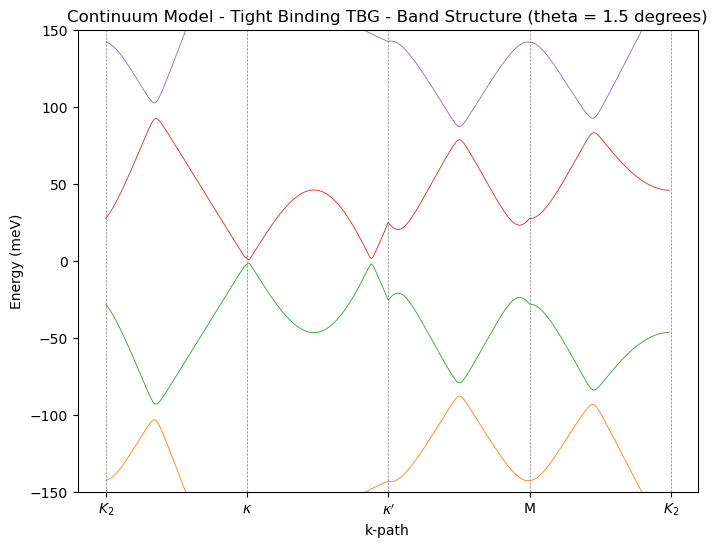

In [23]:
import numpy as np
import matplotlib.pyplot as plt

""" PARAMETERS """
# Parameters
n_layers = 3
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 6582.12  # Fermi Velocity + Plank's Constant meV*angstrom

valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

w_ab = 110  # AB Tunneling Amplitudes
ratio = 0.0
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex) # Identity
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex) # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex) # Pauli Y

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def kronecker_delta_momentum(q_diff, q_target):
    return np.all(np.abs(q_diff - q_target) < tolerance)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Calculate reciprocal lattice vectors between layers 1 and 2
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors 

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle,phi):
    return (w_aa * sigma_0 + w_ab * ((np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y) * np.exp(-1j * phi) ) )

# Construction of the relevant Tunneling matrices # phi = lattice relaxation const to control/modulate the stacking configuration
T1_12 = tunneling_matrix(w_aa, w_ab, 0,phi_ABA[0])
T2_12 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,phi_ABA[1])
T3_12 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,phi_ABA[2])


T1_23 = tunneling_matrix(w_aa, w_ab,0, -phi_ABA[0])
T2_23 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3,-phi_ABA[0])
T3_23 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3,-phi_ABA[0])

# Generate moiré lattice vectors
siteN = (2 * N + 1) ** 2
L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    K2 = delk * np.array([0, 0])
    kappa = delk * np.array([np.sqrt(3)/2, -1/2])
    kappa_prime = delk  * np.array([np.sqrt(3)/2, 1/2])
    K2 = delk * np.array([0, 0])
    m = delk * np.array([np.sqrt(3)/2, 0])

    
    # Generate the k-path segments
    kline1 = klines(K2, kappa, npts)
    kline2 = klines(kappa, kappa_prime , npts)
    kline3 = klines(kappa_prime , K2, npts)
    kline4 = klines(K2, m , npts)
    
    
    # Labels for each segment
    klabels = [r'$K_2$', r'$\kappa$', r'$\kappa^{\prime}$', r'M', r'$K_2$']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1),4 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :],kline4[:-1, :])), kcoord, klabels

def Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m):
    # Initialize Hamiltonian
    H = np.zeros((6 * siteN, 6 * siteN), dtype=complex)

    # Loop through each lattice position to calculate q1, q2 and assign to Hamiltonian
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        # Compute q1 and q2 as arrays with x and y components
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m
        q3 = np.array([kx, ky]) - K3m + n1 * G1m + n2 * G2m

        # Assign intralayer terms for each layer
        H[2*i:2*i+2, 2*i:2*i+2] = -hv * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -hv * (valley * q2[0] * sigma_x + q2[1] * sigma_y)
        H[2*i+4*siteN:2*i+4*siteN+2, 2*i+4*siteN:2*i+4*siteN+2] = -hv * (valley * q3[0] * sigma_x + q3[1] * sigma_y)
        # Loop over other sites for interlayer coupling
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]

            # Set Kronecker delta values based on index shifts
            kd_0 = int((m1 == n1) and (m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((m1 == n1 - valley) and (m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((m1 == n1 - valley) and (m2 == n2 - valley))  # Checks if delta_q = q3

            # Combine tunneling matrices based on Kronecker delta values
            T_12 = kd_0 * T1_12 + kd_G1 * T2_12 + kd_G1G2 * T3_12
            T_23 = kd_0 * T1_23 + kd_G1 * T2_23 + kd_G1G2 * T3_23

            # Block assign the tunneling matrix T to the Hamiltonian
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T_12.conjugate().T
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T_12
            
            H[2*i+2*siteN:2*i+2*siteN+2, 2*j+4*siteN:2*j+4*siteN+2] = T_23.conjugate().T
            H[2*j+4*siteN:2*j+4*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = T_23
            
    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)


def calc_bands_HTTG(theta_deg):
    # Convert theta to radians and recalculate delk for the new theta
    theta_rad = np.radians(theta_deg)
    theta_values = [theta_rad, 0.0, -theta_rad]
    delk = 8 * np.pi * np.sin(theta_rad / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
    
    # Recalculate rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Recalculate mBZ vectors G1m and G2m for the given theta
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # Recalculate K-point values and q vectors for the given theta
    K2m = (1/3) * G1m + (2/3) * G2m
    K1m = -(1/3) * G1m - (2/3) * G2m
    K1m = np.dot(rotation_matrix(-2 * np.pi / 3), K1m)
    q1_12 = K1m - K2m
    q2_12 = np.dot(rotation_matrix(2 * np.pi / 3), q1_12)
    q3_12 = np.dot(rotation_matrix(4 * np.pi / 3), q1_12)
    K3m = K2m - q1_12


    # Call the function to plot the band structure for the current theta
    plot_band_structure(Hamiltonian, npts, delk, theta_deg, K1m, K2m, K3m, G1m, G2m)


        

def plot_band_structure(Hamiltonian, npts, delk, theta_deg,K1m, K2m, K3m, G1m, G2m):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = 6 * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg} degrees)")
    plt.ylim(-150, 150)
    plt.show()

def plot_geometry():
    # Calculate reciprocal lattice vectors between layers 1 and 2
    reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
    b1, b2 = reciprocal_vectors

    # Apply rotation to calculate the rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Calculate mBZ vectors G1m and G2m for layers 1 and 2
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # mBZ K-point values
    K1m = (1/3) * G1m + (2/3) * G2m
    K2m = -(1/3) * G1m - (2/3) * G2m
    K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m)
    q1_12 = K2m - K1m
    K3m = K1m - q1_12 

    print(K1m)
    print(K2m)
    print(K3m)
    print(q1_12)

    # Plot vectors
    plt.figure(figsize=(10, 10))
    origin = np.array([0, 0])

    # Plot G1m and G2m
    plt.quiver(*origin, *G1m, color='r', scale=1, scale_units='xy', angles='xy', label='G1m')
    plt.quiver(*origin, *G2m, color='b', scale=1, scale_units='xy', angles='xy', label='G2m')

    # Plot K-points
    plt.scatter(*K1m, color='g', label='K1m')
    plt.scatter(*K2m, color='purple', label='K2m')
    plt.scatter(*K3m, color='orange', label='K3m')

    # Plot q1_12
    plt.quiver(*K1m, *q1_12, color='black', scale=1, scale_units='xy', angles='xy', label='q1_12')

    # Customize plot to center at (0, 0) and set expanded limits
    plt.xlim(-2 * max(abs(G1m[0]), abs(G2m[0])), 2 * max(abs(G1m[0]), abs(G2m[0])))
    plt.ylim(-2 * max(abs(G1m[1]), abs(G2m[1])), 2 * max(abs(G1m[1]), abs(G2m[1])))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.title('Plot of K-points, G vectors, and q vectors')
    plt.legend()
    plt.grid(True)
    plt.show()
    

#plot_geometry()

theta_array = [1.5]

for theta in theta_array:
    calc_bands_HTTG(theta)


